In [1]:
# import necessary modules
import os
import re
import sys
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchinfo
import torchviz
import distributed as dist_fn
from tqdm import tqdm
import lmdb
from dataset import CodeRow
from collections import namedtuple
from scheduler import CycleScheduler

In [2]:
# import models
from models.cnn_classifier import CNNClassifier
from models.s_vae import VAE
from models.pretrainedvgg16_256 import S_VQVAE_VGG
from models.vgg import VGG

### Evaluate models on clean test data

Now lets evaluate trained models of different alpha and beta values by classifying on cifar 10.


In [ ]:
# test data loader for CIFAR-10
def get_test_loader(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    test_dataset = datasets.CIFAR10(root="./cifar10", train=False, download=True, transform=transform)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# inference function for classification
def classify(model, loader, device, model_type):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for img, label in tqdm(loader, desc="Classifying"):
            img, label = img.to(device), label.to(device)
            
            # Adjust forward pass based on model type
            if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
                _, _, logits = model(img)  # Expecting tuple output (z, vq_loss, logits)
            else:  # "cnn_classifier"
                logits = model(img) 
            predictions = logits.argmax(dim=1)
            correct += (predictions == label).sum().item()
            total += label.size(0)

    accuracy = correct / total * 100
    print(f"Classification Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
# extended S-VQVAE model loading function to extract embedding size from model_name
def get_s_vqvae_model_class(model_path):
    # extract the codebook vector size from the filename
    match = re.search(r"emb(\d+)", model_path)
    if not match:
        raise ValueError(f"Could not find codebook vector size in filename: {model_path}")
    
    emb_size = match.group(1)

    # map the size to the appropriate module and class import
    model_imports = {
        "512": "models.s_vqvae_emb512",
        "256": "models.s_vqvae_emb256",
        "128": "models.s_vqvae_emb128",
        "64": "models.s_vqvae_emb64",
        "10": "models.s_vqvae_emb10"
    }

    if emb_size not in model_imports:
        raise ValueError(f"Unsupported codebook vector size: {emb_size}")

    module_name = model_imports[emb_size]
    module = __import__(module_name, fromlist=['S_VQVAE'])
    return module.S_VQVAE

In [ ]:
import torch
import torch.nn as nn
from models.cnn_classifier import CNNClassifier
from models.s_vae import VAE
from models.pretrainedvgg16_256 import S_VQVAE_VGG  

# additional loading function for all models combined
def load_model(model_path, device):

    model_classes = {
        "cnn_classifier": CNNClassifier(num_classes=10),
        "vae": VAE(),
    }

    try:
        s_vqvae_class = get_s_vqvae_model_class(model_path)
        model_classes["s_vqvae"] = s_vqvae_class()
    except ValueError as ve:
        print(f"S_VQVAE Import Error: {ve}")

    if "s_vqvae_vgg" in model_path.lower():
        model_classes["s_vqvae_vgg"] = S_VQVAE_VGG()
    elif "vgg16" in model_path.lower():
        model_classes["vgg16"] = VGG()

    try:
        checkpoint = torch.load(model_path, map_location='cpu')
    except FileNotFoundError:
        raise ValueError(f"File not found: {model_path}")
    except Exception as e:
        raise ValueError(f"Failed to load checkpoint: {e}")

    for model_type, model in model_classes.items():
        try:
            model_state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

            # quick check if keys in model match the checkpoint
            model_keys = set(model.state_dict().keys())
            checkpoint_keys = set(model_state_dict.keys())

            if not model_keys.issubset(checkpoint_keys):
                print(f"Key mismatch for {model_type}. Skipping...")
                continue

            # load state dict
            model.load_state_dict(model_state_dict, strict=False)
            model.to(device)
            model.eval()

            print(f"Successfully loaded {model_path} as {model_type}")
            return model, model_type

        except RuntimeError as re:
            print(f"RuntimeError for {model_type}: {re}")
        except KeyError as ke:
            print(f"KeyError for {model_type}: {ke}")
        except Exception as e:
            print(f"Unexpected error for {model_type}: {e}")

    raise ValueError(f"Model loading failed for {model_path}. No compatible architecture found.")


In [ ]:
# evaluate models
def evaluate_models(folder_path, batch_size, device):
    test_loader = get_test_loader(batch_size=batch_size)
    model_files = [f for f in os.listdir(folder_path) if f.endswith((".pt", ".pth"))]

    results = []

    for model_file in model_files:
        print(f"\nEvaluating model: {model_file}")
        model_path = os.path.join(folder_path, model_file)

        # load model and determine its type
        model, model_type = load_model(model_path, device)

        # classify and record accuracy
        accuracy = classify(model, test_loader, device, model_type)
        results.append({"model_name": model_file, "clean_accuracy": accuracy})

    # convert results to a DataFrame
    return pd.DataFrame(results)

In [ ]:
# execute evaluation
folder_path = "./best_model/test_latent256"  # Path to the folder containing models
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# run evaluation for all models
df = evaluate_models(folder_path, batch_size, device)

# display DataFrame
from IPython.display import display
display(df)

# save the DataFrame to a CSV file for later use
df.to_csv("results/test_latent256/test_latent256_clean_accuracy_results.csv", index=False)

Files already downloaded and verified


C:\Users\joopt\AppData\Local\Temp\ipykernel_402200\3245720578.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')



Evaluating model: cnn_classifier.pth
S_VQVAE Import Error: Could not find codebook vector size in filename: ./best_model/test_latent256\cnn_classifier.pth
Successfully loaded ./best_model/test_latent256\cnn_classifier.pth as cnn_classifier


Classifying: 100%|██████████| 157/157 [00:05<00:00, 30.39it/s]


Classification Accuracy: 69.31%

Evaluating model: cnn_classifier_delayedat.pth
S_VQVAE Import Error: Could not find codebook vector size in filename: ./best_model/test_latent256\cnn_classifier_delayedat.pth
Successfully loaded ./best_model/test_latent256\cnn_classifier_delayedat.pth as cnn_classifier


Classifying: 100%|██████████| 157/157 [00:04<00:00, 33.06it/s]


Classification Accuracy: 76.81%

Evaluating model: svqvae_emb256.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256.pt as s_vqvae


Classifying: 100%|██████████| 157/157 [00:05<00:00, 29.94it/s]


Classification Accuracy: 80.84%

Evaluating model: svqvae_emb256_cd_delayedat_marginchange.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256_cd_delayedat_marginchange.pt as s_vqvae


Classifying: 100%|██████████| 157/157 [00:04<00:00, 32.42it/s]


Classification Accuracy: 74.63%

Evaluating model: svqvae_emb256_cd_delayedat_marginchange_codereset.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256_cd_delayedat_marginchange_codereset.pt as s_vqvae


Classifying: 100%|██████████| 157/157 [00:05<00:00, 30.87it/s]


Classification Accuracy: 72.20%

Evaluating model: svqvae_emb256_cd_delayedat_marginchange_cyclesched.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256_cd_delayedat_marginchange_cyclesched.pt as s_vqvae


Classifying: 100%|██████████| 157/157 [00:05<00:00, 30.92it/s]


Classification Accuracy: 73.19%

Evaluating model: svqvae_emb256_cd_marginbased.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256_cd_marginbased.pt as s_vqvae


Classifying: 100%|██████████| 157/157 [00:05<00:00, 30.76it/s]


Classification Accuracy: 83.60%

Evaluating model: svqvae_emb256_delayedat.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256_delayedat.pt as s_vqvae


Classifying: 100%|██████████| 157/157 [00:05<00:00, 31.37it/s]

Classification Accuracy: 70.32%


,model_name,clean_accuracy
0,cnn_classifier.pth,69.31
1,cnn_classifier_delayedat.pth,76.81
2,svqvae_emb256.pt,80.84
3,svqvae_emb256_cd_delayedat_marginchange.pt,74.63
4,svqvae_emb256_cd_delayedat_marginchange_codere...,72.20
5,svqvae_emb256_cd_delayedat_marginchange_cycles...,73.19
6,svqvae_emb256_cd_marginbased.pt,83.60
7,svqvae_emb256_delayedat.pt,70.32


#### Corruption Analysis

Analysis on corruption accuracy provided by CIFAR-10-C.

In [ ]:
# CIFAR-10-C dataset
class CIFAR10C(Dataset):
    def __init__(self, data_path, corruption_type, severity, transform=None):

        self.data = np.load(f"{data_path}/{corruption_type}.npy")  # shape: (5 * N, H, W, C)
        self.labels = np.load(f"{data_path}/labels.npy")  # shape: (5 * N,)
        self.severity = severity 
        self.transform = transform

        # determine the range of indices for the given severity
        total_severities = 5
        num_samples = len(self.labels) // total_severities
        start_idx = (self.severity - 1) * num_samples
        end_idx = self.severity * num_samples

        # slice data and labels
        self.data = self.data[start_idx:end_idx]
        self.labels = self.labels[start_idx:end_idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # select data and label
        image = self.data[idx]  # Shape: [H, W, C] or [H, W]
        label = self.labels[idx]

        if image.ndim == 2:  # grayscale image
            image = np.stack([image] * 3, axis=-1)  # Convert to [H, W, C]

        # convert image to channel-first format
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # [H, W, C] -> [C, H, W]

        # apply additional transforms if provided
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# inference on CIFAR-10-C
def evaluate_on_cifar10c(model, data_path, batch_size, device, model_type):
    corruptions = [
        "gaussian_noise", "shot_noise", "impulse_noise", "defocus_blur", "motion_blur", "zoom_blur", "snow", "frost",
        "fog", "brightness", "contrast", "elastic_transform", "pixelate", "jpeg_compression", "speckle_noise",
        "gaussian_blur", "spatter", "saturate"
    ]

    transform = transforms.Compose([
        
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize CIFAR-10-C images
    ])

    results = {}  # store accuracies for each corruption and severity
    corruption_averages = {}  # store average accuracy per corruption
    total_accuracy = 0.0
    total_entries = 0

    for corruption in corruptions:
        results[corruption] = []
        corruption_total = 0.0
        corruption_count = 0

        for severity in range(1, 6): 
            try:
                dataset = CIFAR10C(data_path, corruption, severity, transform=transform)
                if len(dataset) == 0:  
                    print(f"Skipping {corruption}, severity {severity}: no samples")
                    continue

                dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in dataloader:
                        images, labels = images.to(device), labels.to(device)
                        if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
                            _, _, logits = model(images)
                        else:  # "cnn_classifier"
                            logits = model(images) 
                        _, predicted = torch.max(logits, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                results[corruption].append(accuracy)
                corruption_total += accuracy
                corruption_count += 1
                print(f"Corruption: {corruption}, Severity: {severity}, Accuracy: {accuracy:.2f}%")

            except Exception as e:
                print(f"Error processing {corruption}, severity {severity}: {e}")
                results[corruption].append(None)

        # calculate and store the average accuracy for this corruption
        if corruption_count > 0:
            corruption_avg = corruption_total / corruption_count
            corruption_averages[corruption] = corruption_avg
            total_accuracy += corruption_total
            total_entries += corruption_count
        else:
            corruption_averages[corruption] = None
            print(f"No valid data for corruption: {corruption}")

    # calculate the overall average accuracy across all corruptions and severities
    total_avg_accuracy = total_accuracy / total_entries if total_entries > 0 else None

    return results, corruption_averages, total_avg_accuracy


In [ ]:
# save results df
def save_results_to_dataframe(results, corruption_averages, total_avg_accuracy, model_name, existing_df=None):

    row = {"model_name": model_name, **corruption_averages, "avg_accuracy": total_avg_accuracy}

    # convert to DataFrame
    df = pd.DataFrame([row])

    # merge with existing DataFrame if provided
    if existing_df is not None:
        df = pd.concat([existing_df, df], ignore_index=True)

    return df




In [ ]:
def run_inference_for_all_models(folder_path, data_path, batch_size, device):
    combined_df = None
    model_files = [f for f in os.listdir(folder_path) if f.endswith((".pt", ".pth"))]

    for model_file in model_files:
        model_path = os.path.join(folder_path, model_file)
        print(f"\nEvaluating model: {model_file}")

        # load model and determine its type
        model, model_type = load_model(model_path, device)

        # evaluate model on CIFAR-10-C
        results, corruption_averages, total_avg_accuracy = evaluate_on_cifar10c(
            model, data_path, batch_size, device, model_type
        )

        combined_df = save_results_to_dataframe(results, corruption_averages, total_avg_accuracy,
                                                model_name=model_file, existing_df=combined_df)

    return combined_df

In [ ]:
# test models on CIFAR-10-C
folder_path = "./best_model/test_latent256" 
data_path = "./CIFAR-10-C" 
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# run inference for all models and combine results
df = run_inference_for_all_models(folder_path, data_path, batch_size, device)

# display the DataFrame
from IPython.display import display
display(df)

# save the DataFrame to a CSV file for later use
df.to_csv("results/test_latent256/test_latent256_corruption_inference_results.csv", index=False)

C:\Users\joopt\AppData\Local\Temp\ipykernel_402200\3245720578.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')



Evaluating model: cnn_classifier.pth
S_VQVAE Import Error: Could not find codebook vector size in filename: ./best_model/test_latent256\cnn_classifier.pth
Successfully loaded ./best_model/test_latent256\cnn_classifier.pth as cnn_classifier
Corruption: gaussian_noise, Severity: 1, Accuracy: 14.49%
Corruption: gaussian_noise, Severity: 2, Accuracy: 13.91%
Corruption: gaussian_noise, Severity: 3, Accuracy: 13.62%
Corruption: gaussian_noise, Severity: 4, Accuracy: 13.39%
Corruption: gaussian_noise, Severity: 5, Accuracy: 13.47%
Corruption: shot_noise, Severity: 1, Accuracy: 14.82%
Corruption: shot_noise, Severity: 2, Accuracy: 14.36%
Corruption: shot_noise, Severity: 3, Accuracy: 13.65%
Corruption: shot_noise, Severity: 4, Accuracy: 13.26%
Corruption: shot_noise, Severity: 5, Accuracy: 13.17%
Corruption: impulse_noise, Severity: 1, Accuracy: 13.92%
Corruption: impulse_noise, Severity: 2, Accuracy: 13.41%
Corruption: impulse_noise, Severity: 3, Accuracy: 13.26%
Corruption: impulse_noise, S

,model_name,gaussian_noise,shot_noise,impulse_noise,defocus_blur,motion_blur,zoom_blur,snow,frost,fog,brightness,contrast,elastic_transform,pixelate,jpeg_compression,speckle_noise,gaussian_blur,spatter,saturate,avg_accuracy
0,cnn_classifier.pth,13.776,13.852,13.396,13.294,11.206,12.640,13.438,10.740,11.010,12.422,10.694,12.644,16.638,15.650,13.706,12.892,14.548,15.470,13.223111
1,cnn_classifier_delayedat.pth,10.136,10.192,10.102,10.176,10.114,10.158,10.034,9.996,9.990,10.074,9.732,10.164,10.146,10.208,10.208,10.158,10.164,10.732,10.138000
2,svqvae_emb256.pt,15.194,16.052,15.120,22.960,21.396,23.954,17.856,16.682,18.832,20.750,14.694,21.946,19.704,21.070,16.024,22.280,18.658,21.872,19.169111
3,svqvae_emb256_cd_delayedat_marginchange.pt,14.660,14.634,14.528,13.690,13.392,13.602,11.810,10.636,10.624,12.386,10.462,13.486,14.180,14.292,14.598,13.476,14.320,13.632,13.244889
4,svqvae_emb256_cd_delayedat_marginchange_codere...,19.348,20.140,17.486,22.310,21.252,21.920,21.540,17.952,17.134,21.322,15.514,22.322,22.882,22.864,19.992,21.818,21.620,20.236,20.425111
5,svqvae_emb256_cd_delayedat_marginchange_cycles...,13.992,13.982,13.588,13.446,13.082,13.264,11.680,10.388,10.450,12.134,10.376,13.220,13.368,13.652,13.974,13.220,13.748,15.566,12.951667
6,svqvae_emb256_cd_marginbased.pt,15.178,15.824,14.840,20.164,19.034,20.850,16.754,16.322,16.842,18.458,15.628,18.718,17.992,18.060,15.764,20.090,16.984,20.442,17.663556
7,svqvae_emb256_delayedat.pt,11.320,11.154,11.152,10.420,10.346,10.396,10.416,10.050,10.038,10.202,10.032,10.424,10.874,10.942,11.108,10.362,11.086,11.236,10.642111


#### Adversarial Perturbations

Let's continue testing the model for stability against adversarial perturbation of samples with the metric Flip Probability provided by CIFAR-10-P.

In [ ]:
# CIFAR-10-P dataset class for adversarial perturbations
class CIFAR10P(Dataset):
    def __init__(self, data_path, perturbation_type, transform=None):
        self.data = np.load(f"{data_path}/{perturbation_type}.npy")  # shape: (N, T, H, W, C)
        self.labels = np.load(f"{data_path}/labels.npy")  # shape: (N,)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sequence = self.data[idx]  # shape: (T, H, W, C)
        label = self.labels[idx]

        if self.transform:
            sequence = [self.transform(frame) for frame in sequence]

        return torch.stack(sequence), label

In [ ]:
# predictions for perturbations
def predict_on_cifar10p(model, dataloader, device, model_type):
    model.eval()
    flip_counts = 0
    total_transitions = 0

    for sequences, _ in dataloader:
        sequences = sequences.to(device)  # shape: (B, T, C, H, W)
        batch_size, time_steps, _, _, _ = sequences.shape

        predictions = []
        for t in range(time_steps):
            with torch.no_grad():
                if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
                    _, _, logits = model(sequences[:, t])  
                else:  # "cnn_classifier"
                    logits = model(sequences[:, t]) 
                preds = logits.argmax(dim=1)  
                predictions.append(preds)

        predictions = torch.stack(predictions, dim=1)  # Shape: (B, T)

        # compute Flip Probability
        flips = (predictions[:, 1:] != predictions[:, :-1]).sum().item()
        transitions = (time_steps - 1) * batch_size

        flip_counts += flips
        total_transitions += transitions

    return flip_counts / total_transitions

In [ ]:
# dataset benchmark for perturbations on CIFAR-10
def benchmark_cifar10p(model, data_path, perturbations, batch_size, device, model_type):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    results = {}
    total_fp = 0

    for perturbation in perturbations:
        dataset = CIFAR10P(data_path=data_path, perturbation_type=perturbation, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        fp = predict_on_cifar10p(model, dataloader, device, model_type)
        results[perturbation] = fp
        total_fp += fp
        print(f"Perturbation: {perturbation}, Flip Probability: {fp:.4f}")

    overall_fp = total_fp / len(perturbations)
    return results, overall_fp

In [ ]:
# save to DataFrame
def save_results_to_dataframe(results, overall_fp, model_name, existing_df=None):
    row = {"model_name": model_name, **results, "avg_flip_probability": overall_fp}

    # convert the row to a DataFrame
    df = pd.DataFrame([row])

    # merge with existing DataFrame if provided
    if existing_df is not None:
        df = pd.concat([existing_df, df], ignore_index=True)

    return df

In [ ]:
# perturbed inference for all models
def run_inference_for_all_models(folder_path, data_path, perturbations, batch_size, device):
    combined_df = None
    model_files = [f for f in os.listdir(folder_path) if f.endswith((".pt", ".pth"))]

    for model_file in model_files:
        model_path = os.path.join(folder_path, model_file)
        print(f"\nEvaluating model: {model_file}")
        
        # load model and determine its type
        model, model_type = load_model(model_path, device)
        results, overall_fp = benchmark_cifar10p(model, data_path, perturbations, batch_size, device, model_type)

        # save results
        combined_df = save_results_to_dataframe(results, overall_fp, model_name=model_file, existing_df=combined_df)

    return combined_df

In [ ]:
# execute inference on CIFAR-10-P
folder_path = "./best_model/test_latent256"  # Folder containing the .pt and .pth files
data_path = "./CIFAR-10-P"  # Path to CIFAR-10-P dataset
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

perturbations = [
        "brightness", "gaussian_blur", "gaussian_noise", "gaussian_noise_2", "gaussian_noise_3", "motion_blur", "rotate", "scale",
        "shear", "shot_noise", "shot_noise_2", "shot_noise_3", "snow", "spatter", "speckle_noise", "speckle_noise_2", "speckle_noise_3",
        "tilt", "translate", "zoom_blur"
    ]

# Run inference for all models and combine results
df = run_inference_for_all_models(folder_path, data_path, perturbations, batch_size, device)

# Display the DataFrame
from IPython.display import display
display(df)

# Optionally, save the DataFrame to a CSV file for later use
df.to_csv("results/test_latent256/test_latent256_adversarial_perturbation_results.csv", index=False)


Evaluating model: cnn_classifier.pth
S_VQVAE Import Error: Could not find codebook vector size in filename: ./best_model/test_latent256\cnn_classifier.pth
Successfully loaded ./best_model/test_latent256\cnn_classifier.pth as cnn_classifier


C:\Users\joopt\AppData\Local\Temp\ipykernel_402200\3245720578.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


Perturbation: brightness, Flip Probability: 0.0160
Perturbation: gaussian_blur, Flip Probability: 0.0154
Perturbation: gaussian_noise, Flip Probability: 0.0444
Perturbation: gaussian_noise_2, Flip Probability: 0.0896
Perturbation: gaussian_noise_3, Flip Probability: 0.1217
Perturbation: motion_blur, Flip Probability: 0.0812
Perturbation: rotate, Flip Probability: 0.0472
Perturbation: scale, Flip Probability: 0.0883
Perturbation: shear, Flip Probability: 0.0428
Perturbation: shot_noise, Flip Probability: 0.0567
Perturbation: shot_noise_2, Flip Probability: 0.0752
Perturbation: shot_noise_3, Flip Probability: 0.1012
Perturbation: snow, Flip Probability: 0.0277
Perturbation: spatter, Flip Probability: 0.0302
Perturbation: speckle_noise, Flip Probability: 0.0548
Perturbation: speckle_noise_2, Flip Probability: 0.0768
Perturbation: speckle_noise_3, Flip Probability: 0.1044
Perturbation: tilt, Flip Probability: 0.0268
Perturbation: translate, Flip Probability: 0.1212
Perturbation: zoom_blur,

,model_name,brightness,gaussian_blur,gaussian_noise,gaussian_noise_2,gaussian_noise_3,motion_blur,rotate,scale,shear,...,shot_noise_3,snow,spatter,speckle_noise,speckle_noise_2,speckle_noise_3,tilt,translate,zoom_blur,avg_flip_probability
0,cnn_classifier.pth,0.016000,0.015350,0.044397,0.089550,0.121680,0.081220,0.047183,0.088290,0.042810,...,0.101150,0.027683,0.030247,0.054793,0.076823,0.104410,0.026837,0.121187,0.008193,0.061488
1,cnn_classifier_delayedat.pth,0.016007,0.006383,0.015587,0.031220,0.046247,0.040640,0.018573,0.037590,0.018807,...,0.038413,0.011003,0.021287,0.020240,0.026890,0.039737,0.010220,0.055440,0.003413,0.025153
2,svqvae_emb256.pt,0.025587,0.020280,0.056857,0.120787,0.161520,0.098075,0.065967,0.111287,0.059380,...,0.141343,0.037247,0.037150,0.073783,0.105937,0.144767,0.039710,0.168693,0.013507,0.083100
3,svqvae_emb256_cd_delayedat_marginchange.pt,0.030720,0.011600,0.026077,0.043747,0.062907,0.057000,0.034767,0.059280,0.033520,...,0.051897,0.019577,0.031570,0.030460,0.039677,0.053843,0.022847,0.077407,0.008663,0.038275
4,svqvae_emb256_cd_delayedat_marginchange_codere...,0.029170,0.012077,0.026227,0.046737,0.066933,0.055260,0.031253,0.055953,0.030657,...,0.053997,0.017427,0.029660,0.030077,0.040217,0.055040,0.019970,0.070007,0.008053,0.037431
5,svqvae_emb256_cd_delayedat_marginchange_cycles...,0.034540,0.012623,0.028187,0.045557,0.064407,0.056895,0.037790,0.062693,0.035617,...,0.053730,0.020147,0.031930,0.032367,0.041317,0.056737,0.024877,0.081180,0.009990,0.040209
6,svqvae_emb256_cd_marginbased.pt,0.018373,0.018870,0.048653,0.109263,0.168010,0.105665,0.052633,0.102460,0.047683,...,0.132430,0.033647,0.033170,0.062790,0.091613,0.139520,0.030167,0.136453,0.010380,0.074618
7,svqvae_emb256_delayedat.pt,0.037917,0.014360,0.031593,0.051187,0.069310,0.062330,0.043393,0.068530,0.041463,...,0.059080,0.021047,0.035020,0.036917,0.046790,0.061630,0.028780,0.087520,0.011517,0.044616


### PGD Attack Baseline

To further evaluate adversarial robustness, a PGD attack baseline is created for 10 and 20 iterations.

Compared will be accuracy and stability (Flip Probability).

In [ ]:
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CIFAR-10 Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified


In [ ]:
# PGD attack
def pgd_attack(model, images, labels, model_type, eps=8/255, alpha=2/255, iters=10):
    adv_images = images.clone().detach().to(device) 

    for _ in range(iters):
        adv_images.requires_grad_() 
        
        outputs = model(adv_images)

        # Handle tuple output for S-VQVAE
        if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
            _, _, logits = outputs 
        else:
            logits = outputs
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        
        with torch.no_grad():
            adv_images = adv_images + alpha * adv_images.grad.sign()
            perturbation = torch.clamp(adv_images - images, min=-eps, max=eps)
            adv_images = torch.clamp(images + perturbation, min=0, max=1)
            
    return adv_images

In [ ]:
# evaluation for clean accuracy
def evaluate_clean_accuracy(model, dataloader, model_type):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
                _, _, logits = outputs  
            else:
                logits = outputs
            
            preds = logits.argmax(dim=1) 
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [ ]:
# PGD Attack robustness evaluation
def evaluate_pgd_robustness(model, dataloader, model_type, eps=8/255, alpha=2/255, iters=10):
    model.eval()
    correct, total = 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        adv_images = pgd_attack(model, images, labels, model_type, eps, alpha, iters)
        
        outputs = model(adv_images)
        
        if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
            _, _, logits = outputs 
        else:
            logits = outputs
        
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return correct / total

In [ ]:
# stability evaluation with flip rate
def compute_flip_rate(model, dataloader, model_type, eps=8/255, alpha=2/255, iters=10):
    model.eval()
    flip_count, total = 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
            _, _, logits = outputs 
        else:
            logits = outputs
        
        clean_preds = logits.argmax(dim=1)

        # adversarial predictions
        adv_images = pgd_attack(model, images, labels, model_type, eps, alpha, iters)
        
        adv_outputs = model(adv_images)
        
        if model_type in ["s_vqvae", "vae", "s_vqvae_vgg"]:
            _, _, adv_logits = adv_outputs
        else:
            adv_logits = adv_outputs
        
        adv_preds = adv_logits.argmax(dim=1)
        
        flip_count += (clean_preds != adv_preds).sum().item()
        total += labels.size(0)

    return flip_count / total


In [ ]:
# benchmark models accordingly
def benchmark_models(folder_path, dataloader, eps, alpha, iters_list=[10, 20]):
    results_df = pd.DataFrame() 
    model_files = [f for f in os.listdir(folder_path) if f.endswith(('.pt', '.pth'))]

    for model_file in model_files:
        model_path = os.path.join(folder_path, model_file)
        print(f"\nEvaluating model: {model_file}")

        model, model_type = load_model(model_path, device)
        
        clean_acc = evaluate_clean_accuracy(model, dataloader, model_type)
        model_results = {"model_name": model_file, "clean_accuracy": clean_acc}

        # loop through PGD iterations and collect results
        for iters in iters_list:
            pgd_acc = evaluate_pgd_robustness(model, dataloader, model_type, eps, alpha, iters)
            flip_rate = compute_flip_rate(model, dataloader, model_type, eps, alpha, iters)

            model_results[f"pgd_{str(iters)}_accuracy"] = pgd_acc
            model_results[f"flip_rate_{str(iters)}"] = flip_rate

            print(f"PGD-{iters} Accuracy: {pgd_acc:.4f}, Flip Rate: {flip_rate:.4f}")

        # append the combined result for this model directly to the DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([model_results])], ignore_index=True)

    return results_df


In [ ]:
# process variables and initialization
folder_path = './best_model/test_latent256'
eps = 8/255
alpha = 2/255
iters_list = [10, 20]

results_df = benchmark_models(folder_path, test_loader, eps, alpha, iters_list)

# display and save results
from IPython.display import display
display(results_df)

results_df.to_csv('results/test_latent256/test_latent256_pgd_stability_comparison.csv', index=False)


Evaluating model: cnn_classifier.pth
S_VQVAE Import Error: Could not find codebook vector size in filename: ./best_model/test_latent256\cnn_classifier.pth
Successfully loaded ./best_model/test_latent256\cnn_classifier.pth as cnn_classifier


C:\Users\joopt\AppData\Local\Temp\ipykernel_402200\3245720578.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


PGD-10 Accuracy: 0.0685, Flip Rate: 0.8349
PGD-20 Accuracy: 0.0646, Flip Rate: 0.8405

Evaluating model: cnn_classifier_delayedat.pth
S_VQVAE Import Error: Could not find codebook vector size in filename: ./best_model/test_latent256\cnn_classifier_delayedat.pth
Successfully loaded ./best_model/test_latent256\cnn_classifier_delayedat.pth as cnn_classifier
PGD-10 Accuracy: 0.2304, Flip Rate: 0.7056
PGD-20 Accuracy: 0.2293, Flip Rate: 0.7072

Evaluating model: svqvae_emb256.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256.pt as s_vqvae
PGD-10 Accuracy: 0.0328, Flip Rate: 0.9010
PGD-20 Accuracy: 0.0276, Flip Rate: 0.9064

Evaluating model: svqvae_emb256_cd_delayedat_marginchange.pt
Key mismatch for cnn_classifier. Skipping...
Key mismatch for vae. Skipping...
Successfully loaded ./best_model/test_latent256\svqvae_emb256_cd_delayedat_marginchange.pt as s_vqvae
PGD-10 Accuracy: 0.2440, Flip Rate: 0

,model_name,clean_accuracy,pgd_10_accuracy,flip_rate_10,pgd_20_accuracy,flip_rate_20
0,cnn_classifier.pth,0.6931,0.0685,0.8349,0.0646,0.8405
1,cnn_classifier_delayedat.pth,0.7681,0.2304,0.7056,0.2293,0.7072
2,svqvae_emb256.pt,0.8084,0.0328,0.9010,0.0276,0.9064
3,svqvae_emb256_cd_delayedat_marginchange.pt,0.7463,0.2440,0.6858,0.2428,0.6879
4,svqvae_emb256_cd_delayedat_marginchange_codere...,0.7220,0.2310,0.6906,0.2289,0.6923
5,svqvae_emb256_cd_delayedat_marginchange_cycles...,0.7319,0.2402,0.6764,0.2395,0.6777
6,svqvae_emb256_cd_marginbased.pt,0.8360,0.0521,0.8849,0.0468,0.8905
7,svqvae_emb256_delayedat.pt,0.7032,0.2257,0.6875,0.2244,0.6895


#### Results

Now lets put this all together in a more concise way.

In [ ]:
import pandas as pd

# paths to the csv files
clean_accuracy_csv = "results/test_latent256/test_latent256_lossoptim_clean_accuracy_results.csv"  # path to clean accuracy results
corruption_results_csv = "results/test_latent256/test_latent256_lossoptim_corruption_inference_results.csv"  # path to corruption results
flip_probability_csv = "results/test_latent256/test_latent256_lossoptim_adversarial_perturbation_results.csv"  # path to flip probability results
pgd_results_csv = "results/test_latent256/test_latent256_pgd_stability_comparison.csv"  # path to PGD-10 and PGD-20 results

# load csvs
clean_df = pd.read_csv(clean_accuracy_csv)
corruption_df = pd.read_csv(corruption_results_csv)
flip_df = pd.read_csv(flip_probability_csv)
pgd_df = pd.read_csv(pgd_results_csv)

# extract relevant columns for the final table
final_table = pd.DataFrame()
final_table["model_name"] = clean_df["model_name"] 
final_table["clean_accuracy %"] = clean_df["clean_accuracy"] 
final_table["avg_corruption_accuracy %"] = corruption_df["avg_accuracy"].round(2)
final_table["pgd_10_accuracy %"] = pgd_df["pgd_10_accuracy"] * 100
final_table["pgd_20_accuracy %"] = pgd_df["pgd_20_accuracy"] * 100
final_table["flip_probability_CIFAR-P %"] = round((flip_df["avg_flip_probability"] * 100), 2)
final_table["flip_probability_PGD_10 %"] = pgd_df["flip_rate_10"] * 100
final_table["flip_probability_PGD_20 %"] = pgd_df["flip_rate_20"] * 100

# save the final table
final_table_path = "results/test_latent256/test_analysis256.csv"
final_table.to_csv(final_table_path, index=False)

# display the final table
from IPython.display import display
display(final_table)

,model_name,clean_accuracy %,avg_corruption_accuracy %,pgd_10_accuracy %,pgd_20_accuracy %,flip_probability_CIFAR-P %,flip_probability_PGD_10 %,flip_probability_PGD_20 %
0,cnn_classifier.pth,69.31,13.22,6.85,6.46,6.15,83.49,84.05
1,cnn_classifier_delayedat.pth,76.81,10.14,23.04,22.93,2.52,70.56,70.72
2,svqvae_emb256.pt,80.84,19.17,3.28,2.76,8.31,90.10,90.64
3,svqvae_emb256_cd_delayedat_marginchange.pt,74.63,13.24,24.40,24.28,3.83,68.58,68.79
4,svqvae_emb256_cd_delayedat_marginchange_codere...,72.20,20.43,23.10,22.89,3.74,69.06,69.23
5,svqvae_emb256_cd_delayedat_marginchange_cycles...,73.19,12.95,24.02,23.95,4.02,67.64,67.77
6,svqvae_emb256_cd_marginbased.pt,83.60,17.66,5.21,4.68,7.46,88.49,89.05
7,svqvae_emb256_delayedat.pt,70.32,10.64,22.57,22.44,4.46,68.75,68.95


### Additional Tables

#### Naturally Trained Models

In [ ]:
import pandas as pd

final_table_path = "results/test_latent256/test_analysis256.csv"
final_table = pd.read_csv(final_table_path)

# select rows for base model comparison
regular_trained = final_table.iloc[[0, 2, 6]].reset_index(drop=True)

regular_trained.columns = [
    "Model",
    "Clean Acc (%)",
    "Avg Corruption Acc (%)",
    "PGD-10 Acc (%)",
    "PGD-20 Acc (%)",
    "Flip Prob CIFAR-P (%)",
    "Flip Prob PGD-10 (%)",
    "Flip Prob PGD-20 (%)"
]

# change model names for visual clarity
regular_trained["Model"] = ["CNN-Classifier", "S-VQVAE256 ", "S-VQVAE256 Class Divergence"]

regular_trained_path = "results/test_latent256/test_analysis256_regulartrained.csv"
regular_trained.to_csv(regular_trained_path, index=False)

display(regular_trained)

,Model,Clean Acc (%),Avg Corruption Acc (%),PGD-10 Acc (%),PGD-20 Acc (%),Flip Prob CIFAR-P (%),Flip Prob PGD-10 (%),Flip Prob PGD-20 (%)
0,CNN-Classifier,69.31,13.22,6.85,6.46,6.15,83.49,84.05
1,S-VQVAE256,80.84,19.17,3.28,2.76,8.31,90.10,90.64
2,S-VQVAE256 Class Divergence,83.60,17.66,5.21,4.68,7.46,88.49,89.05


#### DelayedAT Models

In [ ]:
# Select rows for DelayedAT comparison
adv_trained = final_table.iloc[[1, 7, 3, 4, 5]].reset_index(drop=True)

adv_trained.columns = [
    "Model",
    "Clean Acc (%)",
    "Avg Corruption Acc (%)",
    "PGD-10 Acc (%)",
    "PGD-20 Acc (%)",
    "Flip Prob CIFAR-P (%)",
    "Flip Prob PGD-10 (%)",
    "Flip Prob PGD-20 (%)"
]

# change model names for visual clarity
adv_trained["Model"] = ["CNN-Classifier DelayedAT", "S-VQVAE256 DelayedAT", "S-VQVAE256 CD DelayedAT", "S-VQVAE256 CD DelayedAT CodeReset", "S-VQVAE256 CD DelayedAT CycleSched"]

adv_trained_path = "results/test_latent256/test_analysis256_advtrained.csv"
adv_trained.to_csv(adv_trained_path, index=False)

display(adv_trained)

,Model,Clean Acc (%),Avg Corruption Acc (%),PGD-10 Acc (%),PGD-20 Acc (%),Flip Prob CIFAR-P (%),Flip Prob PGD-10 (%),Flip Prob PGD-20 (%)
0,CNN-Classifier DelayedAT,76.81,10.14,23.04,22.93,2.52,70.56,70.72
1,S-VQVAE256 DelayedAT,70.32,10.64,22.57,22.44,4.46,68.75,68.95
2,S-VQVAE256 CD DelayedAT,74.63,13.24,24.40,24.28,3.83,68.58,68.79
3,S-VQVAE256 CD DelayedAT CodeReset,72.20,20.43,23.10,22.89,3.74,69.06,69.23
4,S-VQVAE256 CD DelayedAT CycleSched,73.19,12.95,24.02,23.95,4.02,67.64,67.77


#### Class Divergence Loss Effect

In [ ]:
# define numeric columns
numeric_cols = regular_trained.columns[1:]
baseline = regular_trained.loc[0, numeric_cols]

# compute relative robustness
relative_robustness = regular_trained.copy()
relative_robustness[numeric_cols] = regular_trained[numeric_cols] - baseline

# invert the sign for flip probability columns: lower is better
flip_cols = ["Flip Prob CIFAR-P (%)", "Flip Prob PGD-10 (%)", "Flip Prob PGD-20 (%)"]
relative_robustness[flip_cols] = -relative_robustness[flip_cols]

# rename columns to indicate difference
relative_robustness["Model"] = regular_trained["Model"]
relative_robustness.columns = [f"Δ {col}" if col != "Model" else col for col in relative_robustness.columns]

# drop first row
relative_robustness = relative_robustness.iloc[1:].reset_index(drop=True)

# save table
relative_robustness_path = "results/test_latent256/test_analysis256_regular_relativerobustness.csv"
relative_robustness.to_csv(relative_robustness_path, index=False)

display(relative_robustness)

,Model,Δ Clean Acc (%),Δ Avg Corruption Acc (%),Δ PGD-10 Acc (%),Δ PGD-20 Acc (%),Δ Flip Prob CIFAR-P (%),Δ Flip Prob PGD-10 (%),Δ Flip Prob PGD-20 (%)
0,S-VQVAE256,11.53,5.95,-3.57,-3.7,-2.16,-6.61,-6.59
1,S-VQVAE256 Class Divergence,14.29,4.44,-1.64,-1.78,-1.31,-5.0,-5.0


#### DelayedAT

In [ ]:
# define numeric columns
advnumeric_cols = adv_trained.columns[1:]
adv_baseline = adv_trained.loc[0, advnumeric_cols]

# compute relative robustness
adv_relative_robustness = adv_trained.copy()
adv_relative_robustness[advnumeric_cols] = adv_trained[advnumeric_cols] - adv_baseline

# invert the sign for flip probability columns:
flip_cols = ["Flip Prob CIFAR-P (%)", "Flip Prob PGD-10 (%)", "Flip Prob PGD-20 (%)"]
adv_relative_robustness[flip_cols] = -adv_relative_robustness[flip_cols]

# Rename columns to indicate difference
adv_relative_robustness["Model"] = adv_trained["Model"]
adv_relative_robustness.columns = [f"Δ {col}" if col != "Model" else col for col in adv_relative_robustness.columns]

# drop first row
adv_relative_robustness = adv_relative_robustness.iloc[1:].reset_index(drop=True)

# save table
adv_relative_path = "results/test_latent256/test_analysis256_adv_relativerobustness.csv"
adv_relative_robustness.to_csv(adv_relative_path, index=False)

display(adv_relative_robustness)

,Model,Δ Clean Acc (%),Δ Avg Corruption Acc (%),Δ PGD-10 Acc (%),Δ PGD-20 Acc (%),Δ Flip Prob CIFAR-P (%),Δ Flip Prob PGD-10 (%),Δ Flip Prob PGD-20 (%)
0,S-VQVAE256 DelayedAT,-6.49,0.5,-0.47,-0.49,-1.94,1.81,1.77
1,S-VQVAE256 CD DelayedAT,-2.18,3.1,1.36,1.35,-1.31,1.98,1.93
2,S-VQVAE256 CD DelayedAT CodeReset,-4.61,10.29,0.06,-0.04,-1.22,1.5,1.49
3,S-VQVAE256 CD DelayedAT CycleSched,-3.62,2.81,0.98,1.02,-1.5,2.92,2.95


#### Effective Robustness

In [ ]:
# define numeric columns
numeric_cols = regular_trained.columns[1:]
flip_cols = ["Flip Prob CIFAR-P (%)", "Flip Prob PGD-10 (%)", "Flip Prob PGD-20 (%)"]

# create an empty DataFrame for effective robustness
effective_robustness = adv_trained.copy()

# define reference rows from regular_trained for each row in adv_trained
reference_indices = [0, 1, 2, 2, 2] 

# subtract the appropriate reference row
for i, ref_idx in enumerate(reference_indices):
    baseline = regular_trained.loc[ref_idx, numeric_cols]
    effective_robustness.loc[i, numeric_cols] = adv_trained.loc[i, numeric_cols] - baseline

# invert the sign for flip probability columns: lower is better
effective_robustness[flip_cols] = -effective_robustness[flip_cols]

# rename columns to indicate delta
effective_robustness.columns = [f"Δ {col}" if col != "Model" else col for col in effective_robustness.columns]

display(effective_robustness)

# Save to CSV
effective_robustness_path = "results/test_latent256/test_analysis256_effectiverobustness.csv"
effective_robustness.to_csv(effective_robustness_path, index=False)

,Model,Δ Clean Acc (%),Δ Avg Corruption Acc (%),Δ PGD-10 Acc (%),Δ PGD-20 Acc (%),Δ Flip Prob CIFAR-P (%),Δ Flip Prob PGD-10 (%),Δ Flip Prob PGD-20 (%)
0,CNN-Classifier DelayedAT,7.50,-3.08,16.19,16.47,3.63,12.93,13.33
1,S-VQVAE256 DelayedAT,-10.52,-8.53,19.29,19.68,3.85,21.35,21.69
2,S-VQVAE256 CD DelayedAT,-8.97,-4.42,19.19,19.60,3.63,19.91,20.26
3,S-VQVAE256 CD DelayedAT CodeReset,-11.40,2.77,17.89,18.21,3.72,19.43,19.82
4,S-VQVAE256 CD DelayedAT CycleSched,-10.41,-4.71,18.81,19.27,3.44,20.85,21.28


### Visualization

Now let's make some graphs from the previously obtained results:

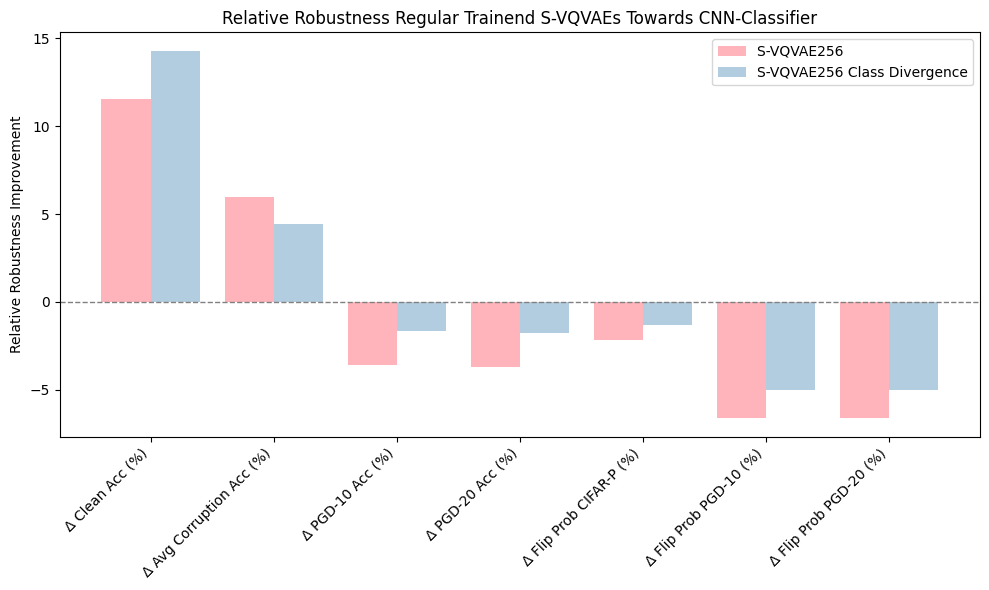

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = [col for col in relative_robustness.columns if col != "Model"]

labels = numeric_cols
x = np.arange(len(labels))

num_rows = relative_robustness.shape[0]

width = 0.8 / num_rows

pastel_colors = [
    "#FFB3BA",  
    "#B3CDE0", 
    "#B4E7B0",  
    "#D3D3D3", 
    "#FFDAC1"   
]

fig, ax = plt.subplots(figsize=(10, 6))

# plot each row as a separate bar group
for i in range(num_rows):
    row_label = relative_robustness.at[i, "Model"]
    row_data = relative_robustness.loc[i, numeric_cols].values.astype(float)

    # position the bars for this row
    offset = (i - (num_rows - 1) / 2) * width
    ax.bar(
        x + offset,
        row_data,
        width,
        label=row_label,
        color=pastel_colors[i % len(pastel_colors)]
    )

# add a horizontal line at y=0
ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_ylabel("Relative Robustness Improvement")
ax.set_title("Relative Robustness Regular Trainend S-VQVAEs Towards CNN-Classifier")
ax.legend()

plt.tight_layout()

plt.savefig("results/test_latent256/relative_robustness_regular_bar_chart.png", dpi=500, bbox_inches="tight")

plt.show()


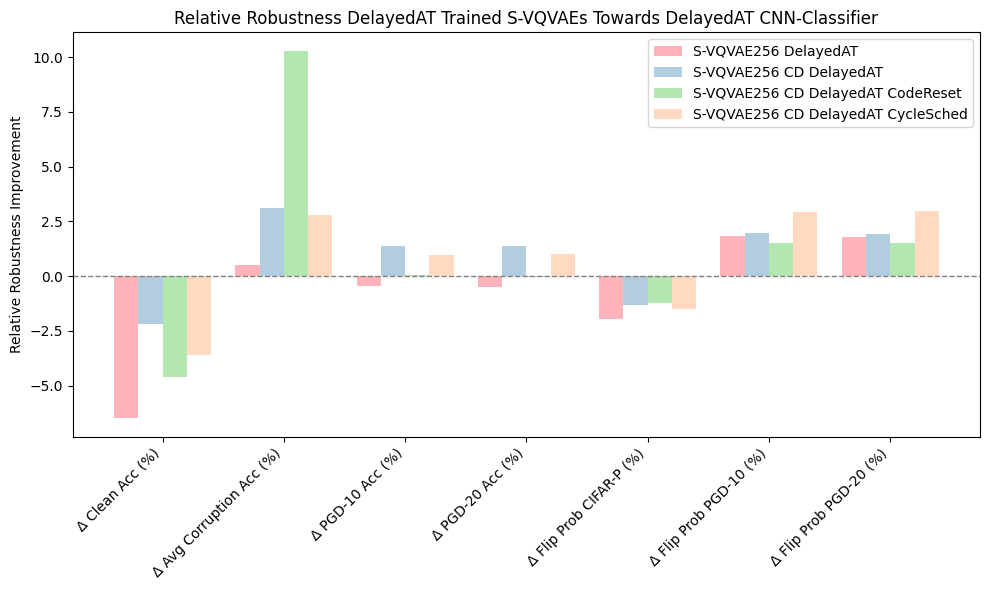

In [ ]:
# Relative Robustness DelayedAT Trained S-VQVAEs Towards DelayedAT CNN-Classifier
numeric_cols = [col for col in adv_relative_robustness.columns if col != "Model"]

labels = numeric_cols
x = np.arange(len(labels))

num_rows = adv_relative_robustness.shape[0]

width = 0.8 / num_rows

pastel_colors = [
    "#FFB3BA",  
    "#B3CDE0",  
    "#B4E7B0", 
    "#FFDAC1",   
    "#D3D3D3"  
    
]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(num_rows):
    row_label = adv_relative_robustness.at[i, "Model"]
    row_data = adv_relative_robustness.loc[i, numeric_cols].values.astype(float)

    offset = (i - (num_rows - 1) / 2) * width
    ax.bar(
        x + offset,
        row_data,
        width,
        label=row_label,
        color=pastel_colors[i % len(pastel_colors)]
    )

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_ylabel("Relative Robustness Improvement")
ax.set_title("Relative Robustness DelayedAT Trained S-VQVAEs Towards DelayedAT CNN-Classifier")
ax.legend()

plt.tight_layout()

plt.savefig("results/test_latent256/relative_robustness_delayedat_bar_chart.png", dpi=600, bbox_inches="tight")

plt.show()

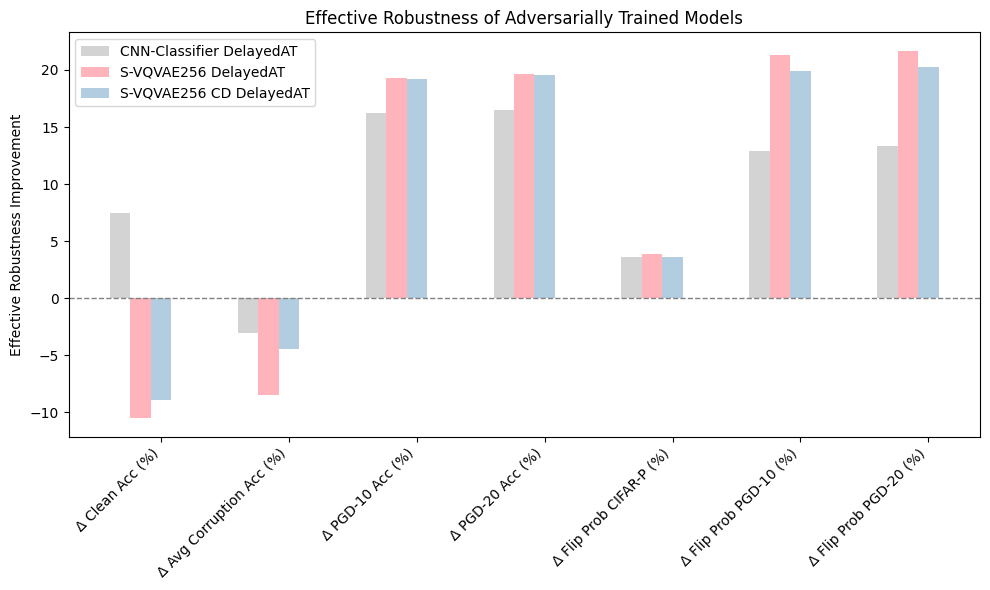

In [ ]:
# Effective Robustness of Adversarially Trained Models
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = [col for col in effective_robustness.columns if col != "Model"]

labels = numeric_cols
x = np.arange(len(labels))

num_rows = effective_robustness.shape[0]

width = 0.8 / num_rows

pastel_colors = [
    "#D3D3D3",  
    "#FFB3BA",
    "#B3CDE0",  
    "#CBF0F8",  
    "#D7AEFB"   
]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(3):
    row_label = effective_robustness.at[i, "Model"]
    row_data = effective_robustness.loc[i, numeric_cols].values.astype(float)
    
    offset = (i - (num_rows - 1) / 2) * width
    ax.bar(
        x + offset,
        row_data,
        width,
        label=row_label,
        color=pastel_colors[i % len(pastel_colors)]
    )

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_ylabel("Effective Robustness Improvement")
ax.set_title("Effective Robustness of Adversarially Trained Models")
ax.legend()

plt.tight_layout()

plt.savefig("results/test_latent256/effective_robustness_delayedat_bar_chart.png", dpi=500, bbox_inches="tight")

plt.show()


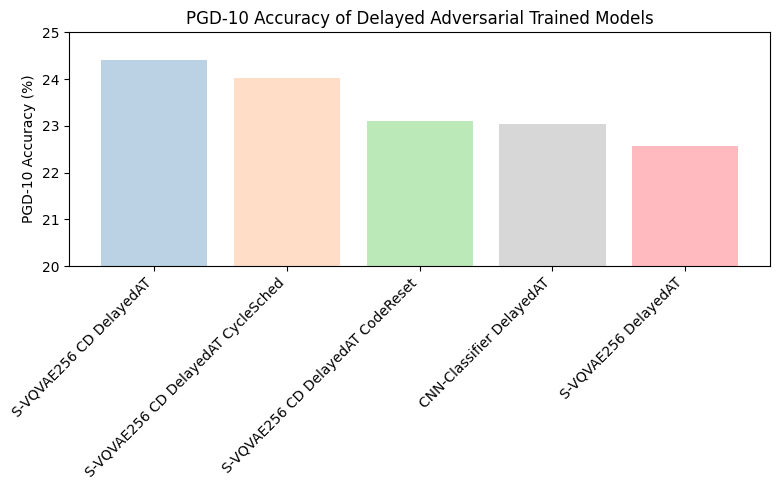

In [ ]:
# PGD-10 Accuracy of Delayed Adversarial Trained Models
import matplotlib.pyplot as plt
import numpy as np

# sort adv_trained by the "PGD-10 Acc (%)" column descending
adv_trained_sorted = adv_trained.sort_values("PGD-10 Acc (%)", ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(adv_trained_sorted))

pastel_colors = ["#B3CDE0", "#FFDAC1", "#B4E7B0", "#D3D3D3", "#FFB3BA"]

ax.bar(
    x,
    adv_trained_sorted["PGD-10 Acc (%)"],
    color=[pastel_colors[i % len(pastel_colors)] for i in range(len(adv_trained_sorted))],
    alpha=0.9
)

ax.set_ylim(20, 25)

ax.set_xticks(x)
ax.set_xticklabels(adv_trained_sorted["Model"], rotation=45, ha='right')

ax.set_ylabel("PGD-10 Accuracy (%)")
ax.set_title("PGD-10 Accuracy of Delayed Adversarial Trained Models")

plt.tight_layout()
plt.savefig("results/test_latent256/pgd10_acc_bar_chart.png", dpi=500, bbox_inches="tight")
plt.show()


### Specific Corruption Analysis

Let's also analyze individual corruptions

In [ ]:
# relative corruption for individual values
import pandas as pd

# load the original table
csv_path = "results/test_latent256/test_latent256_lossoptim_corruption_inference_results.csv"
df = pd.read_csv(csv_path)

pairs = [
    (2, 0),  # row 2 minus row 0
    (6, 0),  # row 6 minus row 0
    (7, 1),  # row 7 minus row 1
    (3, 1),  # row 3 minus row 1
]

relative_rows = []
for (model_idx, baseline_idx) in pairs:
    row_data = df.iloc[model_idx].copy()
    
    row_data.iloc[1:] = df.iloc[model_idx, 1:] - df.iloc[baseline_idx, 1:]
    
    relative_rows.append(row_data)

relative_corruption = pd.DataFrame(relative_rows).reset_index(drop=True)

original_cols = relative_corruption.columns.tolist()
rename_dict = {original_cols[0]: "model"}
for col in original_cols[1:]:
    rename_dict[col] = f"Δ {col}"

relative_corruption.rename(columns=rename_dict, inplace=True)

new_names = [
    "S-VQVAE256",
    "S-VQVAE256 CD",
    "S-VQVAE256 DelayedAT",
    "S-VQVAE256 CD DelayedAT"
]
relative_corruption["model"] = new_names

display(relative_corruption)

relative_corruption_path = "results/test_latent256/test_latent256_relative_corruption_robustness.csv"
relative_corruption.to_csv(relative_corruption_path, index=False)


,model,Δ gaussian_noise,Δ shot_noise,Δ impulse_noise,Δ defocus_blur,Δ motion_blur,Δ zoom_blur,Δ snow,Δ frost,Δ fog,Δ brightness,Δ contrast,Δ elastic_transform,Δ pixelate,Δ jpeg_compression,Δ speckle_noise,Δ gaussian_blur,Δ spatter,Δ saturate,Δ avg_accuracy
0,S-VQVAE256,1.418,2.200,1.724,9.666,10.190,11.314,4.418,5.942,7.822,8.328,4.000,9.302,3.066,5.420,2.318,9.388,4.110,6.402,5.946000
1,S-VQVAE256 CD,1.402,1.972,1.444,6.870,7.828,8.210,3.316,5.582,5.832,6.036,4.934,6.074,1.354,2.410,2.058,7.198,2.436,4.972,4.440444
2,S-VQVAE256 DelayedAT,1.184,0.962,1.050,0.244,0.232,0.238,0.382,0.054,0.048,0.128,0.300,0.260,0.728,0.734,0.900,0.204,0.922,0.504,0.504111
3,S-VQVAE256 CD DelayedAT,4.524,4.442,4.426,3.514,3.278,3.444,1.776,0.640,0.634,2.312,0.730,3.322,4.034,4.084,4.390,3.318,4.156,2.900,3.106889


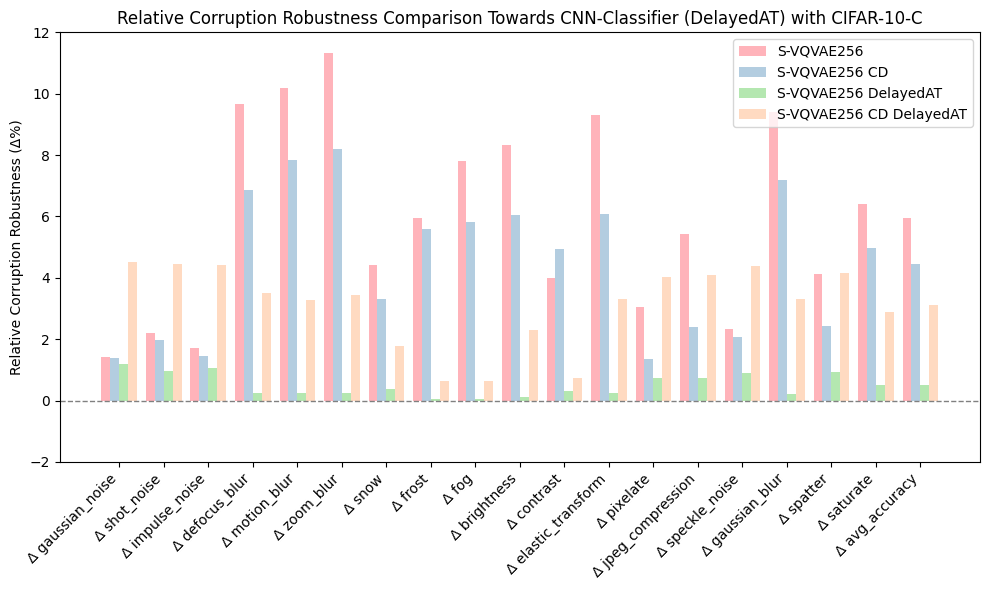

In [ ]:
# Relative Corruption Robustness Comparison Towards CNN-Classifier (DelayedAT) with CIFAR-10-C
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = [col for col in relative_corruption.columns if col != "model"]

labels = numeric_cols
x = np.arange(len(labels))

num_rows = relative_corruption.shape[0]

width = 0.8 / num_rows

pastel_colors = [
    "#FFB3BA",  
    "#B3CDE0", 
    "#B4E7B0",  
    "#FFDAC1", 
    "#D3D3D3"   
]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(num_rows):
    row_label = relative_corruption.at[i, "model"]
    row_data = relative_corruption.loc[i, numeric_cols].values.astype(float)

    offset = (i - (num_rows - 1) / 2) * width
    ax.bar(
        x + offset,
        row_data,
        width,
        label=row_label,
        color=pastel_colors[i % len(pastel_colors)]
    )

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_ylim(-2, 12)

ax.set_ylabel("Relative Corruption Robustness (Δ%)")
ax.set_title("Relative Corruption Robustness Comparison Towards CNN-Classifier (DelayedAT) with CIFAR-10-C")
ax.legend()

plt.tight_layout()
plt.savefig("results/test_latent256/relative_corruption_robustness_bar_chart.png", 
            dpi=500, bbox_inches="tight")
plt.show()
